In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

#### 데이터 로드

In [30]:
dj_co2 = pd.read_csv('dj_co2.csv')
im = pd.read_csv('dj_co2_2.csv')

dj_co2['traffic'] = im['traffic']

In [31]:
dj_co2

,grid_cd,emissions,geometry,pop,household,urbanization_index,traffic
0,라바0013,62.71,POLYGON ((127.50000000000001 36.31434675521236...,43.0,23.0,0.000000,0.0
1,라바0014,65.21,POLYGON ((127.50000000000001 36.32336221829146...,28.0,13.0,0.497484,0.0
2,라바0015,1240.97,POLYGON ((127.50000000000001 36.33237766774219...,5.0,0.0,0.000000,6969.0
3,라바0016,922.49,POLYGON ((127.50000000000001 36.34139310356320...,5.0,5.0,0.000000,34955.0
4,라바0017,7123.83,POLYGON ((127.50000000000001 36.35040852575323...,33.0,18.0,0.000000,28762.0
...,...,...,...,...,...,...,...
627,다바9924,27.36,POLYGON ((127.48884610188327 36.41351557840409...,13.0,8.0,0.003658,0.0
628,다바9925,0.00,POLYGON ((127.48884481266187 36.42253089132852...,0.0,0.0,0.000000,0.0
629,다바9926,0.00,POLYGON ((127.48884352286736 36.43154619061015...,0.0,0.0,0.000000,0.0
630,다바9927,0.00,POLYGON ((127.48884223249948 36.44056147624773...,0.0,0.0,0.000000,0.0


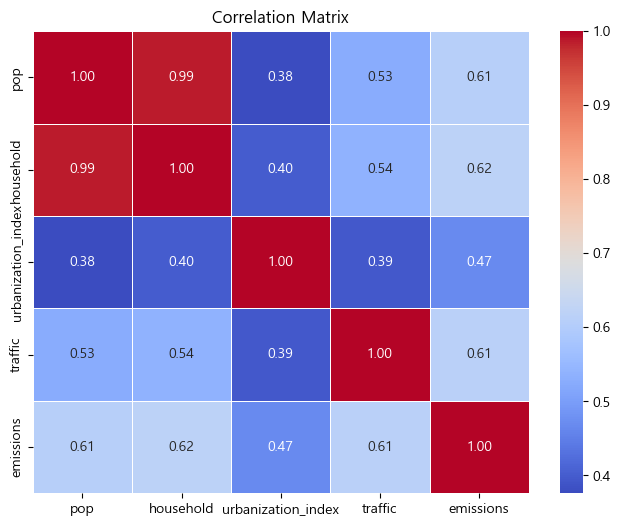

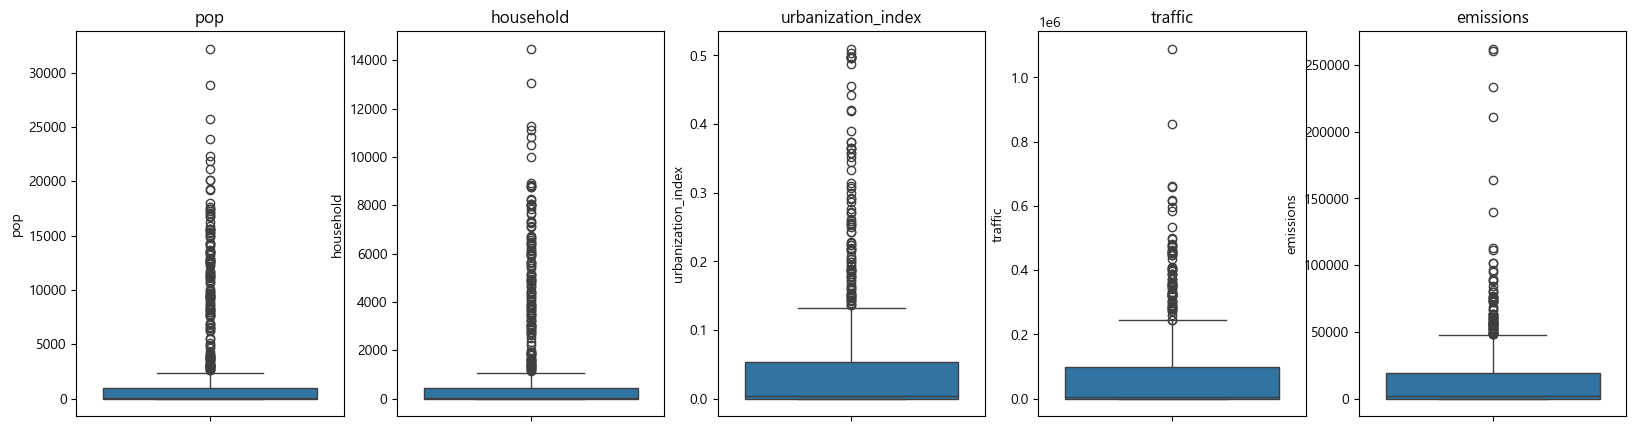

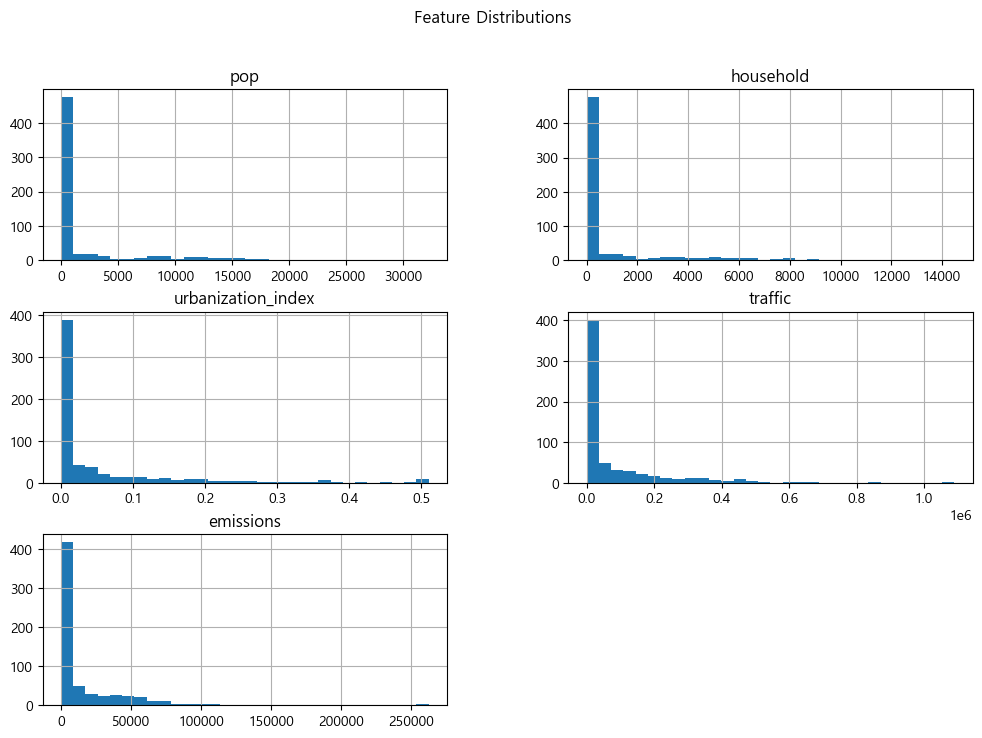

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관 행렬 확인
correlation_matrix = dj_co2[['pop', 'household', 'urbanization_index', 'traffic', 'emissions']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# 이상치 확인을 위한 박스플롯 시각화
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
features = ['pop', 'household', 'urbanization_index', 'traffic', 'emissions']
for i, feature in enumerate(features):
    sns.boxplot(y=dj_co2[feature], ax=axes[i])
    axes[i].set_title(feature)
plt.show()

# 데이터 분포 확인을 위한 히스토그램
dj_co2[features].hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions")
plt.show()


In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# 다중공선성(VIF) 확인
X = dj_co2[['pop', 'household', 'urbanization_index', 'traffic']]
X = np.log1p(X)  # 로그 변환하여 이상치 영향 완화

vif_data = pd.DataFrame()
vif_data["Feature"] = ['pop', 'household', 'urbanization_index', 'traffic']
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [39]:
vif_data

,Feature,VIF
0,pop,54.467393
1,household,53.169431
2,urbanization_index,1.613714
3,traffic,3.624736


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 다중공선성이 높은 'household' 제거
features = ['pop', 'urbanization_index', 'traffic']
X = dj_co2[features]
y = dj_co2['emissions']

# 로그 변환 (이상치 영향 완화)
X = np.log1p(X)
y = np.log1p(y)

# 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화 (선형 회귀 모델을 위한 표준화)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 초기화
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# 모델 학습 및 평가
results = []
for name, model in models.items():
    if name in ["Linear Regression", "Ridge Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R² Score": r2})

# 결과 출력
results_dj_co2 = pd.DataFrame(results)


In [44]:
results_dj_co2

,Model,MAE,RMSE,R² Score
0,Linear Regression,1.412523,1.774874,0.778985
1,Ridge Regression,1.412742,1.775598,0.778805
2,Random Forest,0.860836,1.216013,0.896256
3,XGBoost,0.895994,1.241921,0.891788


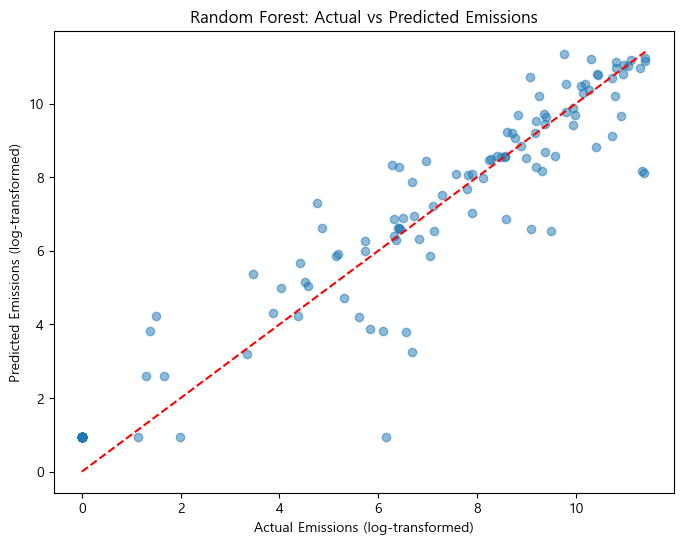

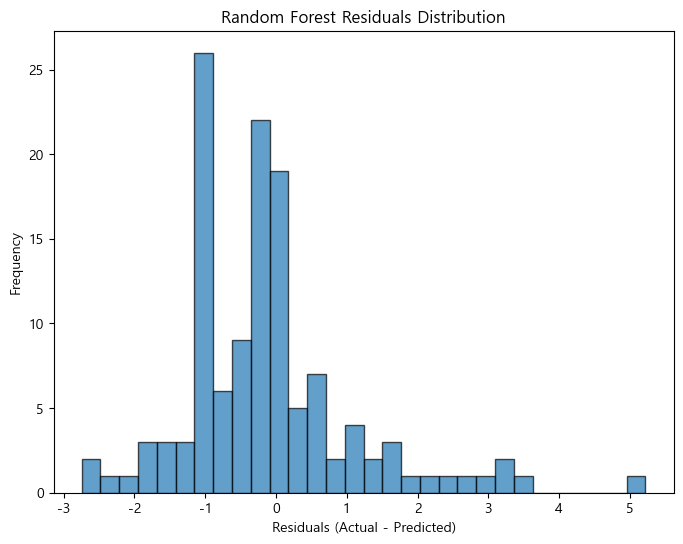

In [ ]:
# 다중공선성이 높은 'household' 제거
features = ['pop', 'urbanization_index', 'traffic']
X = dj_co2[features]
y = dj_co2['emissions']

# 로그 변환 (이상치 영향 완화)
X = np.log1p(X)
y = np.log1p(y)

# 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 실제 vs 예측 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # y=x 직선
plt.xlabel("Actual Emissions (log-transformed)")
plt.ylabel("Predicted Emissions (log-transformed)")
plt.title("Random Forest: Actual vs Predicted Emissions")
plt.show()

# 잔차(Residuals) 분석
residuals = y_test - y_pred_rf

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Random Forest Residuals Distribution")
plt.show()

In [49]:
# 평가 지표 출력
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

evaluation_results = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R² Score"],
    "Random Forest": [mae_rf, rmse_rf, r2_rf]
})

evaluation_results

,Metric,Random Forest
0,MAE,0.860836
1,RMSE,1.216013
2,R² Score,0.896256
